In [1]:
import qiskit.circuit as circuit
import qiskit.pulse as pulse
import qiskit.compiler as compiler
import retworkx.visualization as rxv
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
import numpy as np
import time
from shutil import copyfile
from qiskit.providers.jobstatus import JobStatus
import tqcsf.file
from matplotlib import colors
from qiskit.providers.tergite import Tergite
from qiskit.visualization.pulse_v2.stylesheet import IQXDebugging, IQXSimple

In [2]:
chalmers = Tergite.get_provider()
backend = chalmers.get_backend(input("Backend name? "))

Backend name? Nov7


In [39]:
qubit_idx = 4

In [40]:
qc0 = circuit.QuantumCircuit(5, 5, name="KET0")
qc0.barrier([qubit_idx])
qc0.reset(qubit_idx)
qc0.measure([qubit_idx], [qubit_idx])
qc0.draw()

q_0: ───────────
                
q_1: ───────────
                
q_2: ───────────
                
q_3: ───────────
      ░      ┌─┐
q_4: ─░──|0>─┤M├
      ░      └╥┘
c: 5/═════════╩═
              4

In [41]:
qc1 = circuit.QuantumCircuit(5, 5, name="KET1")
qc1.barrier([qubit_idx])
qc1.reset(qubit_idx)
qc1.rx(np.pi, qubit_idx)
qc1.measure([qubit_idx], [qubit_idx])
qc1.draw()

q_0: ────────────────────
                         
q_1: ────────────────────
                         
q_2: ────────────────────
                         
q_3: ────────────────────
      ░      ┌───────┐┌─┐
q_4: ─░──|0>─┤ Rx(π) ├┤M├
      ░      └───────┘└╥┘
c: 5/══════════════════╩═
                       4

In [42]:
backend.set_options(shots=6000)
job = backend.run([qc0, qc1], meas_level=1, meas_return="single")
while job.status() != JobStatus.DONE:
    time.sleep(1)

data_dict = "C:\\Users\\Axel\\Documents\\tergite-qiskit-connector\\tests\\data\\31oct\\"
new_file = copyfile(job.logfile, data_dict + f"state-disc-q{qubit_idx}.sf")

Tergite: Job has been successfully submitted


In [43]:
sf = tqcsf.file.StorageFile(new_file, mode="r")

In [44]:
sf.tuid

'20221031-084756-091-8f0f21'

In [45]:
states = {}
for tag, data in sf.sort_items(sf.experiments.items()):
    msmt = data[f"slot~{qubit_idx}/measurement"][:]
    states[tag] = data[f"slot~{qubit_idx}/measurement"][0, :]

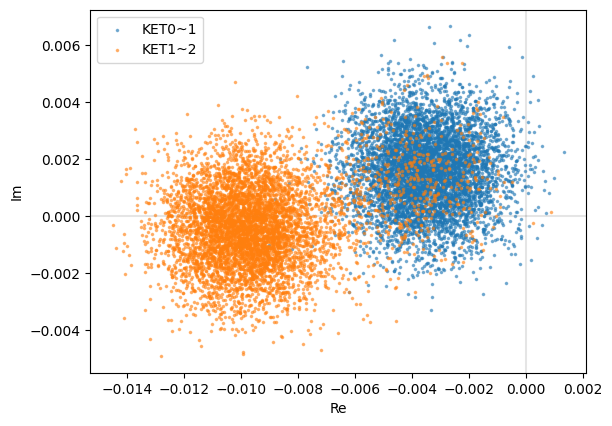

In [46]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot()

label = list()
for tag, pts in states.items():
    label.append(tag)
    ax.scatter(pts.real, pts.imag, s=2.5, alpha=0.5)

ax.set_aspect("equal")
ax.set_xlabel("Re")
ax.set_ylabel("Im")
ax.legend(label)
ax.axvline(0, c="black", alpha=0.1, zorder=-99)
ax.axhline(0, c="black", alpha=0.1, zorder=-99)

In [47]:
assert False, "BREAKPOINT"

AssertionError: BREAKPOINT

# LDA

In [ ]:
import qiskit.circuit as circuit
import qiskit.pulse as pulse
import qiskit.compiler as compiler
import retworkx.visualization as rxv
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
import numpy as np
import time
from shutil import copyfile
import pickle
from qiskit.providers.jobstatus import JobStatus
import tqcsf.file
from matplotlib import colors
from qiskit.providers.tergite import Tergite
from qiskit.visualization.pulse_v2.stylesheet import IQXDebugging, IQXSimple

In [ ]:
qubit_idx = 4
sf = tqcsf.file.StorageFile(f"state-disc-q{qubit_idx}.sf", mode="r")
states = {}
for tag, data in sf.sort_items(sf.experiments.items()):
    msmt = data[f"slot~{qubit_idx}/measurement"][:]
    states[tag] = data[f"slot~{qubit_idx}/measurement"][0, :]

In [ ]:
n_shots = 6000

X = np.zeros((2 * n_shots, 2))
X[:6000, 0] = states["KET0~1"].real
X[:6000, 1] = states["KET0~1"].imag
X[6000:, 0] = states["KET1~2"].real
X[6000:, 1] = states["KET1~2"].imag

lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)

y = np.asarray(np.repeat(0, n_shots).tolist() + np.repeat(1, n_shots).tolist())
y_pred = lda.fit(X, y).predict(X)

tp = y == y_pred  # True Positive
tp0, tp1 = tp[y == 0], tp[y == 1]
X0, X1 = X[y == 0], X[y == 1]
X0_tp, X0_fp = X0[tp0], X0[~tp0]
# print( len( X0_tp),len( X0_fp) )
# print( X0_tp)
X1_tp, X1_fp = X1[tp1], X1[~tp1]
err_ws_0 = len(X0_fp) / len(X0)  # error when sending 0
err_ws_1 = len(X1_fp) / len(X1)  # error when sending 1
print("errors:", err_ws_0, err_ws_1)
# class 0: dots
plt.scatter(
    X0_fp[:, 0],
    X0_fp[:, 1],
    marker="x",
    s=10,
    color="orange",
    label=f"errors when sending |0>: {err_ws_0:.4f}",
)  # dark red


# class 1: dots
plt.scatter(
    X1_fp[:, 0],
    X1_fp[:, 1],
    marker="x",
    s=10,
    color="dodgerblue",
    label=f"errors when sending |1>: {err_ws_1:.4f}",
)
plt.scatter(
    X1_tp[:, 0],
    X1_tp[:, 1],
    marker=".",
    s=10,
    color="blue",
)
plt.scatter(X0_tp[:, 0], X0_tp[:, 1], marker=".", s=10, color="red")


# class 0 and 1 : areas
nx, ny = 200, 100
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx), np.linspace(y_min, y_max, ny))
Z = lda.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z = Z[:, 1].reshape(xx.shape)
plt.pcolormesh(
    xx, yy, Z, cmap="coolwarm", norm=colors.Normalize(0.0, 1), zorder=0, alpha=0.2
)
plt.contour(xx, yy, Z, [0.5], linewidths=4.0, colors="dimgrey")
plt.legend()
# plt.title(f'Fidelity: $1-\\frac{{1}}{{2}}(P(0|1) + P(1|0))$ = {fidelity:.4f} ')

plt.plot(
    lda.means_[0][0],
    lda.means_[0][1],
    "h",
    color="yellow",
    markersize=15,
    markeredgecolor="black",
)

plt.plot(
    lda.means_[1][0],
    lda.means_[1][1],
    "h",
    color="yellow",
    markersize=15,
    markeredgecolor="black",
)


plt.show()